# Classifying Kepler Objects of Interest

The NASA Exoplanet Science Institute keeps an archive of observed objects from the Kepler Mission that may possibly be habitable planets. This dataset contains 9564 observations from this archive, with various characteristics and a label to classify them. The classification, named koi_disposition, sorts each observations into one of three classes: candidate, confirmed, and false positive. Using this dataset, we will try to train a model to classify the observations based on its features.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [19]:
df = pd.read_csv(r"C:\Users\austi\Downloads\cumulative_2020.09.17_20.18.06.csv")
df.sample(5)

,kepid,kepoi_name,kepler_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
3962,8507475,K04300.01,Kepler-1585 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,-179.0,4.517,0.050,-0.150,0.872,0.197,-0.085,296.15900,44.563110,15.965
8522,5380812,K06570.01,NaN,CANDIDATE,CANDIDATE,NaN,0,0,0,0,...,-295.0,3.833,0.277,-0.277,2.637,0.799,-0.917,296.56232,40.590939,10.896
8532,6436505,K06707.01,NaN,CANDIDATE,CANDIDATE,0.993,0,0,0,0,...,-149.0,4.592,0.032,-0.120,0.778,0.141,-0.065,289.70703,41.843540,15.857
1529,11069176,K02007.01,Kepler-1050 b,CONFIRMED,CANDIDATE,0.999,0,0,0,0,...,-78.0,3.877,0.293,-0.098,2.153,0.272,-0.760,282.92499,48.626389,13.127
5389,5360082,K03768.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,...,-151.0,4.679,0.056,-0.028,0.567,0.045,-0.045,291.08334,40.566639,14.772


## Data Preprocessing

Drop error and additional identification features.

In [3]:
#regular expression to identify columns labeled with 'err'(for error)
df_disp = df[df.columns.drop(df.filter(regex='err'))]
df_disp = df_disp.drop(['koi_pdisposition', 'koi_score', 'kepoi_name', 'kepler_name', 'koi_tce_delivname', 'koi_tce_plnt_num'],
                        axis=1).set_index('kepid')

#drop rows with null values
df_disp=df_disp.dropna()

Setting features as X and target variable as y

In [4]:
# koi_disposition is the target variable
y = df_disp['koi_disposition']
#everything remaing except koi_disposition are feature variables
X = df_disp.loc[:, df_disp.columns != 'koi_disposition']

Before fitting the dataset to a model, we should check for any highly correlated features. This can be done using a correlation matrix.

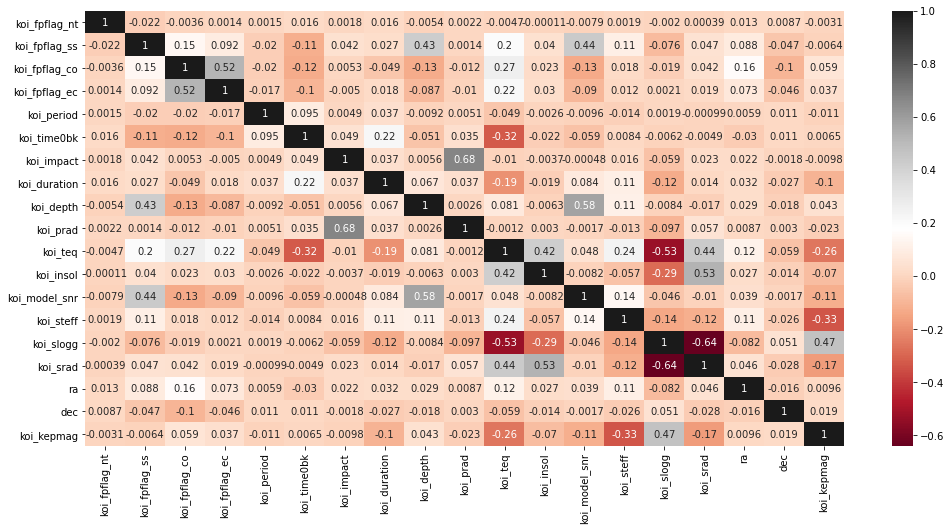

In [5]:
#plot correlation matrix
import matplotlib.pyplot as plt

plt.figure(figsize=(17,8))
cor = X.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.RdGy)
plt.show()

It looks like there are a few pairs of features that are highly correlated:
    1. koi_slogg and koi_srad
    2. koi_insol and koi_srad
    2. koi_impact and koi_prad
    3. koi_depth and koi_model_snr
We will drop one feature from each pair: koi_srad (in two pairs), koi_prad, and koi_depth

In [6]:
X = X.drop(['koi_srad', 'koi_prad', 'koi_depth'], axis=1)

There is a rather large range of values among the dataset, which can cause the classification model to assign incorrect weights to certain features. To account for this, the features will be standardized by removing the mean and scaling to unit variance.

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper
mapper = DataFrameMapper([(X.columns, StandardScaler())])
scaled_features = mapper.fit_transform(X)
X = pd.DataFrame(scaled_features, index=X.index, columns=X.columns)

Checking if there is a target feature imbalance that may affect training the model>

In [21]:
y.value_counts()

FALSE POSITIVE    4582
CONFIRMED         2355
CANDIDATE         2263
Name: koi_disposition, dtype: int64

There looks to be a reasonable spread of target classes. We will not need to over/undersample the dataset.

## Model Training and Parameter Selection

Splitting the dataset into training and test sets.

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

Using Grid Search Cross Validation to identify the optimal parameters for the Random Forest classification model.

In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()

# Number of trees in random forest
n_estimators = [5, 10, 20, 30]
# Maximum number of levels in tree
max_depth = range(2,20)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = range(1,5)

param_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

grid_clf = GridSearchCV(clf, param_grid, cv=8, scoring='accuracy')
grid_clf.fit(X_train, y_train)

GridSearchCV(cv=8, estimator=RandomForestClassifier(),
             param_grid={'max_depth': range(2, 20),
                         'min_samples_leaf': range(1, 5),
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [5, 10, 20, 30]},
             scoring='accuracy')

In [11]:
bscore = grid_clf.best_score_
print(f"The best accuracy score found by the Grid Search is {round(bscore * 100, 2)}%")

The best accuracy score found by the Grid Search is 90.28%


In [12]:
bparams = grid_clf.best_params_
print(f"The Random Forest paramaters that return the best accuracy score is:\n {bparams}")

The Random Forest paramaters that return the best accuracy score is:
 {'max_depth': 17, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 30}


Applying the best paramaters into a final model.

In [14]:
best_params = {'max_depth': 13,
                'min_samples_leaf': 2,
                'min_samples_split': 2,
                'n_estimators': 30}

clf_best = RandomForestClassifier()
clf_best.set_params(**best_params)
clf_best.fit(X_train, y_train)
pred_best = clf_best.predict(X_test)

## ROC AUC Evaluation

Another method of evaluating the model is to display the receiver operating characteristic (ROC) curve and the area under the curve (AUC). This method plots a grapth that shows the performance of the classification model at every classification threshold by plotting two metrics, the True Positive Rate and the False Positive Rate. In this case, since there are three classes in the target variable, three ROC curves are plotted, one for each class.

Since we have a multi-class target variable (CONFIRMED, CANDIDATE, FALSE POSITIVE), we will need to binarize the class labels to plot the ROC curve. Each class with be evaluated separately with its own curve plotted.

In [15]:
from sklearn.preprocessing import label_binarize
y_bin = label_binarize(y, classes=['CONFIRMED', 'CANDIDATE', 'FALSE POSITIVE'])
n_classes = y_bin.shape[1]

X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y_bin, test_size= 0.33, random_state=1)

In [16]:
from sklearn.multiclass import OneVsRestClassifier
classifier = OneVsRestClassifier(clf_best)
y_score = classifier.fit(X_train2, y_train2).predict_proba(X_test2)

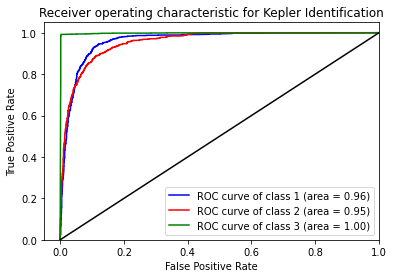

In [17]:
from sklearn.metrics import roc_curve, auc
from itertools import cycle

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test2[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=1.5, label='ROC curve of class {0} (area = {1:0.2f})' ''.format(i+1, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k-', lw=1.5)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for Kepler Identification')
plt.legend(loc="lower right")
plt.show()

### Interpreting the ROC AUC
From the plotted curves, we can see that the Random Forest classifier performs very well in identifying the Kepler distposition, as they nearly reach the top left corner of the chart.

The AUC, or the area under the ROC curve, measures the entire area beneath each curve. The greater the area, the better performing the model. This can be used to compare models or in this case, compare the precision of our classifier model on each target class. The AUC score ranges from 0 to 1, with 0 indicating a model predicting everything wrong and 1 indicating that a model predicts the target perfectly.

The AUC can be interpreted as the probability that our model selects a random actual positive example over a random negative example when predicting positive outcomes. Class 3 (green) is predicted perfectly with a score of 1 and classes 1 (blue) and 2 (red) having near perfect scores of 0.96 and 0.95 respectively.

Now we will plot the actual confusion matrix with the model's predictions.

[[ 705    3   92]
 [   0 1466   13]
 [ 183    6  568]]


C:\Users\austi\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass labels=['CONFIRMED', 'FALSE POSITIVE', 'CANDIDATE'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


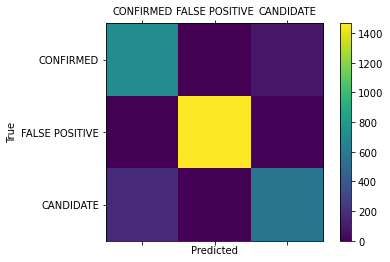

In [18]:
from sklearn.metrics import confusion_matrix

clf_best_2 = RandomForestClassifier()
clf_best_2.set_params(**best_params)
clf_best_2.fit(X_train, y_train)

pred_best = clf_best_2.predict(X_test)

labels = ['CONFIRMED', 'FALSE POSITIVE', 'CANDIDATE']
cm = confusion_matrix(y_test, pred_best, labels)
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()